In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import pandas as pd
from planet_cookbook import read_reports as rr
import os
import rebound
import seaborn as sns

sol_to_earth = 332946.078
G = 6.6743* 10**(-11) #N⋅m2/kg2
M_sun = 1.989e+33 #g
AU = 1.496e+13 #cm

In [2]:
params = {
   'axes.labelsize': 15,
   'font.size': 15,
   'legend.fontsize': 10,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
   'text.usetex': True, #to use TeX in your labels
   'font.family':'serif',
   'axes.titlesize': 15
   }
rcParams.update(params)

In [3]:
#Color-blind friendly pallete
colors = [
    "#0C7BDC",  # Vibrant Blue
    "#E66100",  # Bright Orange
    "#40B0A6",  # Teal/Aqua
    "#8B8D8B",  # Medium Grey
    "#5D3A9B"   # Muted Purple
]

vib_blue = "#0C7BDC"
teal = "#40B0A6"
purple = "#5D3A9B" 

In [4]:
solar_system_df = pd.read_csv('solarsystem.csv')
mercury = solar_system_df[solar_system_df['name'] == 'Mercury']
venus = solar_system_df[solar_system_df['name'] == 'Venus']
earth = solar_system_df[solar_system_df['name'] == 'Earth']
mars = solar_system_df[solar_system_df['name'] == 'Mars']

In [5]:
base_path = "/Users/honeyeah/Codes/data/" #folder with all data

sim_set = "ueda_v3/" #name of simulation set, folder with subfolders the name "sim_set_i"
sim_archive_path = base_path + sim_set + "ueda_v3_" #path given to get_runtime_data function
ueda_v3_rdf = rr.get_runtime_data(sim_archive_path, 10, "ueda_v3_") #rdf is runtime data frame

sim_set = "cham_bench/" #name of simulation set, folder with subfolders the name "sim_set_i"
sim_archive_path = base_path + sim_set + "cham_bench_" #path given to get_runtime_data function
cham_bench_rdf = rr.get_runtime_data(sim_archive_path, 10, "cham_simarchive_") #rdf is runtime data frame

sim_set = "cham_cont/" #name of simulation set, folder with subfolders the name "sim_set_i"
sim_archive_path = base_path + sim_set + "cham_cont_" #path given to get_runtime_data function
cham_cont_rdf = rr.get_runtime_data(sim_archive_path, 10, "cham_cont_") #rdf is runtime data frame

cut_time = 299.9e6

/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

In [6]:
n_runs = 10

maxtimes_ueda_v3 = np.array([
    ueda_v3_rdf[ueda_v3_rdf['simulation_id'] == i + 1]['time'].max()
    for i in range(n_runs)
])

maxtimes_cham_bench = np.array([
    cham_bench_rdf[cham_bench_rdf['simulation_id'] == i + 1]['time'].max()
    for i in range(n_runs)
])

maxtimes_cham_cont = np.array([
    cham_cont_rdf[cham_cont_rdf['simulation_id'] == i + 1]['time'].max()
    for i in range(n_runs)
])

keep_ueda_v3 = np.where(maxtimes_ueda_v3 > 299.9e6)[0]
keep_cham_bench = np.where(maxtimes_cham_bench > 299.9e6)[0]
keep_cham_cont = np.where(maxtimes_cham_cont > 299.9e6)[0]

print("number of finished runs\n")
print(f"ueda_v3: {len(keep_ueda_v3)}")
print(f"cham_bench: {len(keep_cham_bench)}")
print(f"cham_cont: {len(keep_cham_cont)}")

number of finished runs

ueda_v3: 7
cham_bench: 10
cham_cont: 6


In [13]:
#FOR UEDA V3
cut_times = [5e6, 10e6, 20e6, 50e6, 100e6, 299.9e6]
ueda_v3_dataframes = []

for cut in cut_times:
    ueda_v3_ppdf_list = rr.get_particle_params_at_time(
        f"/Users/honeyeah/Codes/data/ueda_v3/ueda_v3_", keep_ueda_v3, "ueda_v3_", cut
    )

    ueda_v3_pldf_list = []
    for j, i in enumerate(keep_ueda_v3):
        if cut == 299.9e6:
           df = rr.read_dbct_output(
            f"/Users/honeyeah/Codes/data/ueda_v3/ueda_v3_{i+1}/uniform_33.txt",
            0.3, "none", "none"
        )
        else:
            df = rr.read_dbct_output(
                f"/Users/honeyeah/Codes/data/ueda_v3/ueda_v3_{i+1}/uniform_33_{int(cut/1e6)}Myrs.txt",
                0.3, "none", "none"
            )

        df_len = len(df)  
        param_len = len(ueda_v3_ppdf_list[j])
        min_len = min(df_len, param_len)

        if min_len == 0:
            print(f"Skipping index {i}: empty df or param list.")
            continue

        # Trim both to same length
        df = df.iloc[:min_len].copy()
        semi_values = ueda_v3_ppdf_list[j]['semi'][:min_len]
        df['semi'] = semi_values.values  # if semi_values is a Series
        df['sim_id'] = i + 1

        ueda_v3_pldf_list.append(df)
        df_at_snapshot = pd.concat(ueda_v3_pldf_list)
        df_at_snapshot['time'] = cut
        ueda_v3_dataframes.append(df_at_snapshot)

ueda_v3_pdframe = pd.concat(ueda_v3_dataframes)

/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

In [14]:
#FOR CHAM_BENCH
cut_times = [5e6, 10e6, 20e6, 50e6, 100e6, 299.9e6]
cham_bench_dataframes = []

for cut in cut_times:
    cham_bench_ppdf_list = rr.get_particle_params_at_time(
        f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_", keep_cham_bench, "cham_simarchive_", cut
    )

    cham_bench_pldf_list = []
    for j, i in enumerate(keep_cham_bench):
        if cut == 299.9e6:
            df = rr.read_dbct_output(
                f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_{i+1}/uniform_33.txt",
                0.3, "none", "none"
            )
        else:
            df = rr.read_dbct_output(
            f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_{i+1}/uniform_33_{int(cut/1e6)}Myrs.txt",
            0.3, "none", "none"
            )

        df_len = len(df)  
        param_len = len(cham_bench_ppdf_list[j])
        min_len = min(df_len, param_len)

        if min_len == 0:
            print(f"Skipping index {i}: empty df or param list.")
            continue

        # Trim both to same length
        df = df.iloc[:min_len].copy()
        semi_values = cham_bench_ppdf_list[j]['semi'][:min_len]
        df['semi'] = semi_values.values  # if semi_values is a Series
        df['sim_id'] = i + 1

        cham_bench_pldf_list.append(df)
        df_at_snapshot = pd.concat(cham_bench_pldf_list)
        df_at_snapshot['time'] = cut
        cham_bench_dataframes.append(df_at_snapshot)

cham_bench_pdframe = pd.concat(cham_bench_dataframes)

/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

In [15]:
#FOR CHAM_CONT
cut_times = [5e6, 10e6, 20e6, 50e6, 100e6, 299.9e6]
cham_cont_dataframes = []

for cut in cut_times:
    cham_cont_ppdf_list = rr.get_particle_params_at_time(
        f"/Users/honeyeah/Codes/data/cham_cont/cham_cont_", keep_cham_cont, "cham_cont_", cut
    )

    cham_cont_pldf_list = []
    for j, i in enumerate(keep_cham_cont):
        if cut == 299.9e6:
            df = rr.read_dbct_output(
                f"/Users/honeyeah/Codes/data/cham_cont/cham_cont_{i+1}/uniform_33.txt",
                0.3, "none", "none"
            )
        else:
            df = rr.read_dbct_output(
                f"/Users/honeyeah/Codes/data/cham_cont/cham_cont_{i+1}/uniform_33_{int(cut/1e6)}Myrs.txt",
                0.3, "none", "none"
            )

        df_len = len(df)  
        param_len = len(cham_cont_ppdf_list[j])
        min_len = min(df_len, param_len)

        if min_len == 0:
            print(f"Skipping index {i}: empty df or param list.")
            continue

        # Trim both to same length
        df = df.iloc[:min_len].copy()
        semi_values = cham_cont_ppdf_list[j]['semi'][:min_len]
        df['semi'] = semi_values.values  # if semi_values is a Series
        df['sim_id'] = i + 1

        cham_cont_pldf_list.append(df)
        df_at_snapshot = pd.concat(cham_cont_pldf_list)
        df_at_snapshot['time'] = cut
        cham_cont_dataframes.append(df_at_snapshot)

cham_cont_pdframe = pd.concat(cham_cont_dataframes)

/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

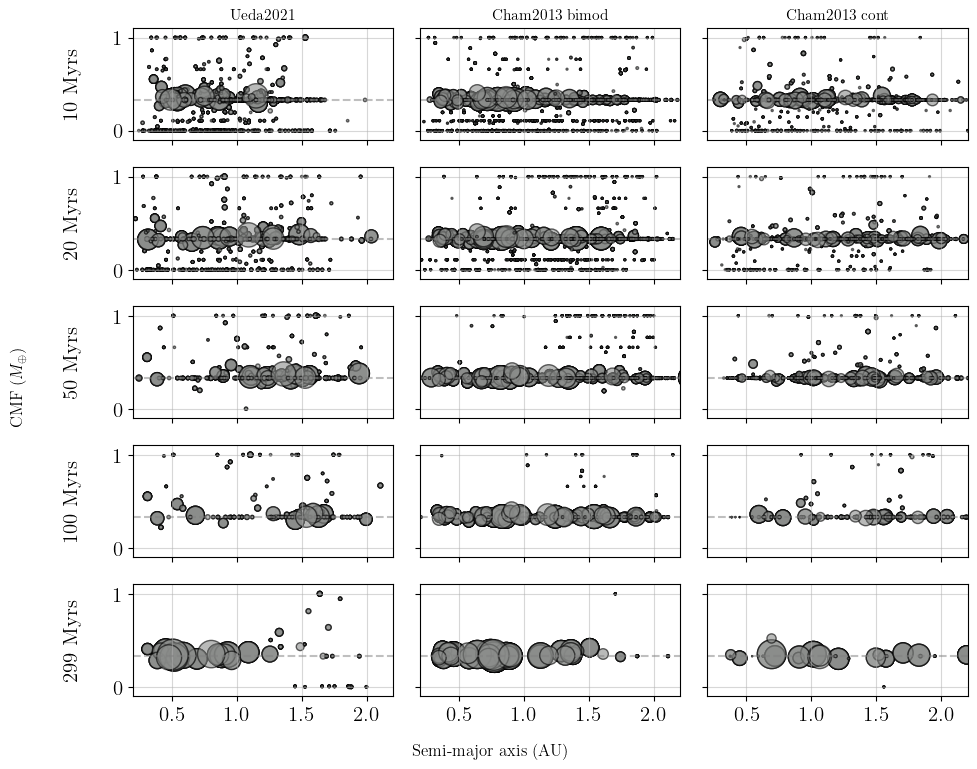

In [18]:
fig, axes = plt.subplots(5, 3, figsize=(10, 8), sharey=True, sharex=True)

datasets = []

times_to_plot = [10e6, 20e6, 50e6, 100e6, 299.9e6]

for t in times_to_plot:
    label_time = int(t / 1e6)  # for display purposes
    datasets.append((f"Ueda2021, {label_time} Myrs", ueda_v3_pdframe[ueda_v3_pdframe['time'] == t], colors[3]))
    datasets.append((f"Cham2013 bimod, {label_time} Myrs", cham_bench_pdframe[cham_bench_pdframe['time'] == t], colors[3]))
    datasets.append((f"Cham2013 cont, {label_time} Myrs", cham_cont_pdframe[cham_cont_pdframe['time'] == t], colors[3]))


dot_scale = 400


row_labels = [f"{int(t/1e6)} Myrs" for t in times_to_plot]
col_labels = ["Ueda2021", "Cham2013 bimod", "Cham2013 cont"]


for i, (label, df, color) in enumerate(datasets):
    ax = axes.flat[i]
    ax.grid(True, alpha=0.5)
    ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

    ax.scatter(df['semi'], df['cmf'], alpha=0.6, color=color,
               edgecolors='black', linewidths=1,
               s=df['mass'] * sol_to_earth * dot_scale)

    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(-0.1, 1.1)

    row = i // 3
    col = i % 3

    # Add column titles only in the first row
    if row == 0:
        ax.set_title(col_labels[col], fontsize=11)

    # Add row labels only in the first column
    if col == 0:
        ax.annotate(row_labels[row], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 15, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='medium', ha='right', va='center', rotation=90)



# Shared axis labels
fig.text(0.5, 0.04, 'Semi-major axis (AU)', ha='center', fontsize=12)
fig.text(0.02, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

#fig.suptitle('Uniform CMF distributions (0.33)')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

#plt.savefig("paper_plots/snapshots.pdf", dpi=300)  # or .png

plt.show()

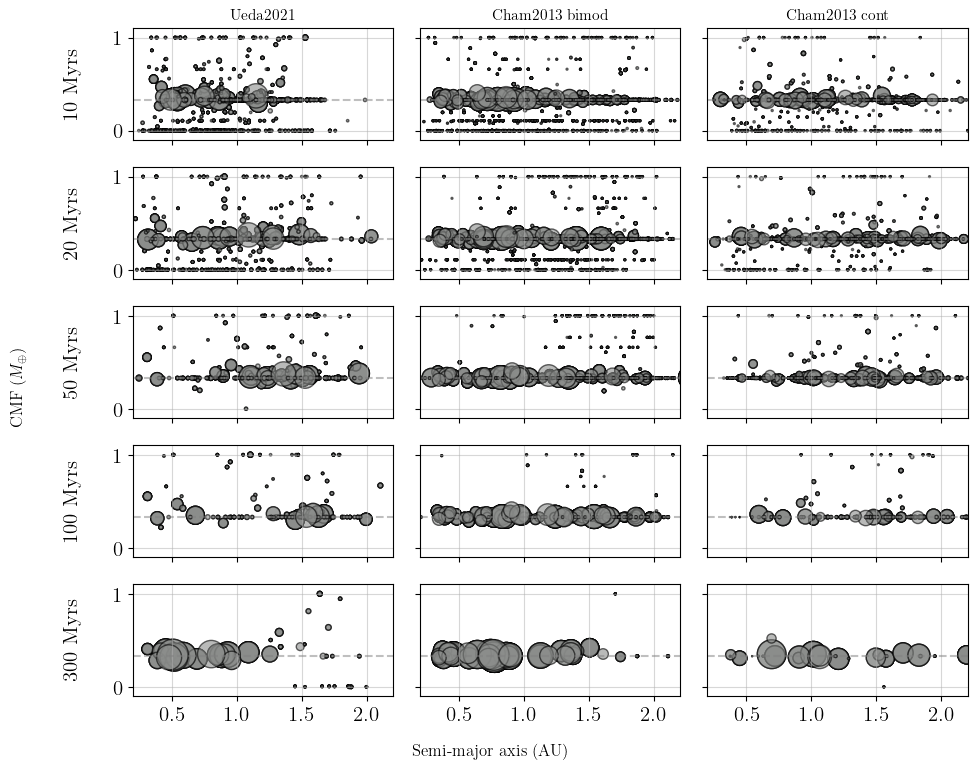

In [19]:
fig, axes = plt.subplots(5, 3, figsize=(10, 8), sharey=True, sharex=True)

datasets = []

times_to_plot = [10e6, 20e6, 50e6, 100e6, 299.9e6]
times_labels = [10e6, 20e6, 50e6, 100e6, 300e6]

for t in times_to_plot:
    label_time = int(t / 1e6)  # for display purposes
    datasets.append((f"Ueda2021, {label_time} Myrs", ueda_v3_pdframe[ueda_v3_pdframe['time'] == t], colors[3]))
    datasets.append((f"Cham2013 bimod, {label_time} Myrs", cham_bench_pdframe[cham_bench_pdframe['time'] == t], colors[3]))
    datasets.append((f"Cham2013 cont, {label_time} Myrs", cham_cont_pdframe[cham_cont_pdframe['time'] == t], colors[3]))


dot_scale = 400


row_labels = [f"{int(t/1e6)} Myrs" for t in times_labels]
col_labels = ["Ueda2021", "Cham2013 bimod", "Cham2013 cont"]


for i, (label, df, color) in enumerate(datasets):
    ax = axes.flat[i]
    ax.grid(True, alpha=0.5)
    ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

    ax.scatter(df['semi'], df['cmf'], alpha=0.6, color=color,
               edgecolors='black', linewidths=1,
               s=df['mass'] * sol_to_earth * dot_scale)

    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(-0.1, 1.1)

    row = i // 3
    col = i % 3

    # Add column titles only in the first row
    if row == 0:
        ax.set_title(col_labels[col], fontsize=11)

    # Add row labels only in the first column
    if col == 0:
        ax.annotate(row_labels[row], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 15, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='medium', ha='right', va='center', rotation=90)



# Shared axis labels
fig.text(0.5, 0.04, 'Semi-major axis (AU)', ha='center', fontsize=12)
fig.text(0.02, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

#fig.suptitle('Uniform CMF distributions (0.33)')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

#plt.savefig("paper_plots/snapshots.pdf", dpi=300)  # or .png

plt.show()